<div class="alert alert-block alert-success">
    <h1 align="center"> Audio Processing with Deep Learning from Zero</h1>
    <h3 align="center">Sound Classification, Step-by-Step</h3>
    <h4 align="center"><a href="http://www.iran-machinelearning.ir">Soheil Tehranipour</a></h5>
</div>

# Intro
**Sound Classification** is one of the most widely used applications in Audio Deep Learning. It involves learning to classify sounds and to predict the category of that sound. This type of problem can be applied to many practical scenarios e.g. classifying music clips to identify the genre of the music, or classifying short utterances by a set of speakers to identify the speaker based on the voice.

Just like classifying hand-written digits using the MNIST dataset is considered a ‘Hello World”-type problem for Computer Vision, we can think of this application as the introductory problem for audio deep learning.

**We will start with sound files, convert them into spectrograms, input them into a CNN plus Linear Classifier model, and produce predictions about the class to which the sound belongs.**

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper.
All excerpts are taken from field recordings uploaded to www.freesound.org. The files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the article above.

In addition to the sound excerpts, a CSV file containing metadata about each excerpt is also provided.


# What we will do:

we will use the Urban Sound 8K dataset that consists of a corpus of ordinary sounds recorded from day-to-day city life. The sounds are taken from 10 classes such as drilling, dogs barking, and sirens. Each sound sample is labeled with the class to which it belongs.

After downloading the dataset, we see that it consists of two parts:

* Audio files in the ‘audio’ folder: It has 10 sub-folders named ‘fold1’ through ‘fold10’. Each sub-folder contains a number of ‘.wav’ audio samples eg. ‘fold1/103074–7–1–0.wav’
* Metadata in the ‘metadata’ folder: It has a file ‘UrbanSound8K.csv’ that contains information about each audio sample in the dataset such as its filename, its class label, the ‘fold’ sub-folder location, and so on. The class label is a numeric Class ID from 0–9 for each of the 10 classes. eg. the number 0 means air conditioner, 1 is a car horn, and so on.

### Methodology

1. There are 3 basic methods to extract features from audio file :

* Using the mffcs data of the audio files
* Using a spectogram image of the audio and then converting the same to data points (As is done forimages). This is easily done using mel_spectogram function of Librosa
* Combining both features to build a better model. (Requires a lot of time to read and extract data).
    
2. I have chosen to use the second method.

3. The labels have been converted to categorical data for classification.

4. CNN has been used as the primary layer to classify data

# Importing Necessary Libraries

In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns

# Specific Libraries
import os
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm, trange
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

import IPython.display as ipd

# Analysing Data Type and Format

There are many suitable datasets available for sounds of different types. These datasets contain a large number of audio samples, along with a class label for each sample that identifies what type of sound it is, based on the problem you are trying to address.

These class labels can often be obtained from some part of the filename of the audio sample or from the sub-folder name in which the file is located. Alternately the class labels are specified in a separate metadata file, usually in TXT, JSON, or CSV format.

In [3]:
df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


##### Column Names

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

#### Using Librosa to analyse random sound sample - SPECTROGRAM

In [4]:
dat1, sampling_rate1 = librosa.load('../input/urbansound8k/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('../input/urbansound8k/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

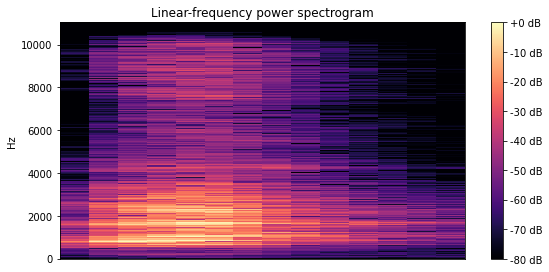

In [5]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

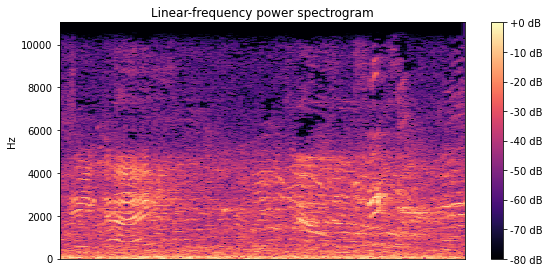

In [6]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

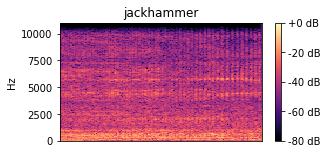

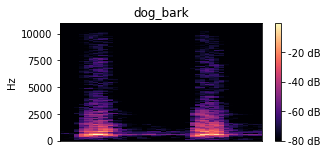

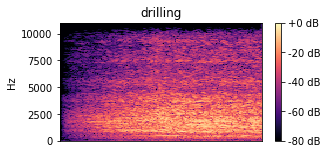

In [7]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = '../input/urbansound8k/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

# Feature Extraction and Database Building

## Mel Spectrograms

* This raw audio is now converted to Mel Spectrograms. A Spectrogram captures the nature of the audio as an image by decomposing it into the set of frequencies that are included in it.

## MFCC

* For human speech, in particular, it sometimes helps to take one additional step and convert the Mel Spectrogram into MFCC (Mel Frequency Cepstral Coefficients). MFCCs produce a compressed representation of the Mel Spectrogram by extracting only the most essential frequency coefficients, which correspond to the frequency ranges at which humans speak.

#### Method

1. I have used Librosa to extract features.
2. To do so, I will go through each fold and extract the data for each file. Then I have used the mel_spectogram function of librosa to extract the spectogram data as a numpy array.
3. After reshaping and cleaning the data, 80-20 split has been performed.
4. Classes (Y) have been converted to Categorically Encoded Data usng Keras.utils

Note : Running the parser function may take few minutes depending on your system since it has to extract spectogram data for 8732 audio files

In [8]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name,res_type='kaiser_fast')
    feature = librosa.feature.mfcc(y=sample,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []
path = '../input/urbansound8k/'

for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data= features_extract(file_name)    
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


In [9]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing
...,...,...
8727,"[-398.5845, 135.53496, -50.725018, 35.855907, ...",car_horn
8728,"[-346.4742, 86.34815, -45.16858, 51.709873, -3...",car_horn
8729,"[-303.88824, 111.35945, -45.941566, 35.877018,...",car_horn
8730,"[-344.11008, 125.45021, -54.903442, 34.891155,...",car_horn


In [10]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())

In [11]:
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [13]:
num_labels = y.shape[1]
model = Sequential()

model.add(Dense(128, input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))

model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

2023-01-16 06:57:47.163903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 06:57:47.164884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 06:57:47.264438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 06:57:47.265339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 06:57:47.266274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=100,
          validation_data=(x_test, y_test),
         )

Epoch 1/100


2023-01-16 06:57:50.741563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


219/219 [==============================] - 3s 4ms/step - loss: 9.6263 - accuracy: 0.1453 - val_loss: 2.1191 - val_accuracy: 0.2438
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 2.3661 - accuracy: 0.2107 - val_loss: 2.0523 - val_accuracy: 0.2250
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 2.0969 - accuracy: 0.2418 - val_loss: 1.9674 - val_accuracy: 0.2444
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 1.9925 - accuracy: 0.2796 - val_loss: 1.8986 - val_accuracy: 0.2851
Epoch 5/100
219/219 [==============================] - 1s 3ms/step - loss: 1.9089 - accuracy: 0.3035 - val_loss: 1.7745 - val_accuracy: 0.3612
Epoch 6/100
219/219 [==============================] - 1s 3ms/step - loss: 1.8271 - accuracy: 0.3459 - val_loss: 1.6463 - val_accuracy: 0.4591
Epoch 7/100
219/219 [==============================] - 1s 3ms/step - loss: 1.7377 - accuracy: 0.3844 - val_loss: 1.5898 - val_accuracy: 0.4894
Epoch 8/100

In [16]:
def extract_feature(file_name):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
    scaled = np.mean(fea.T,axis=0)
    return np.array([scaled])

In [17]:
def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n') 

In [18]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [19]:
print_prediction('../input/urbansound8k/fold2/100652-3-0-2.wav')
ipd.Audio('../input/urbansound8k/fold2/100652-3-0-2.wav')

The predicted class is: dog_bark 



In [20]:
print_prediction('../input/urbansound8k/fold5/100263-2-0-137.wav')
ipd.Audio('../input/urbansound8k/fold5/100263-2-0-137.wav')

The predicted class is: children_playing 



In [21]:
print_prediction('../input/urbansound8k/fold7/102853-8-0-2.wav')
ipd.Audio('../input/urbansound8k/fold7/102853-8-0-2.wav')

The predicted class is: siren 

